In [1]:
import sys, os
import torch, wandb
import torch.nn as nn
from torch.utils.data import DataLoader
sys.path.append(os.path.abspath(os.path.join(os.curdir, '..')))

In [2]:
from configs import DPT_config as config
from models.dpt import DPT
from datasets.depth_dataset import DepthDataset
import utils.train_utils as tu
from utils.train_utils import train_model

/home/v.lomtev/env/CIL/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set a fixed random seed for reproducibility
torch.manual_seed(config.random_seed)

train_full_dataset = DepthDataset(
    data_dir=os.path.join(config.dataset_path, 'train/train'),
    list_file=os.path.join(config.dataset_path, 'train_list.txt'), 
    transform=config.transform_train,
    target_transform=config.target_transform,
    has_gt=True)
    
    # Create test dataset without ground truth
test_dataset = DepthDataset(
    data_dir=os.path.join(config.dataset_path, 'test/test'),
    list_file=os.path.join(config.dataset_path, 'test_list.txt'),
    transform=config.transform_val,
    has_gt=False)  # Test set has no ground truth
    
# Split training dataset into train and validation
total_size = len(train_full_dataset)
train_size = int((1-config.val_part) * total_size)  
val_size = total_size - train_size    
    
train_dataset, val_dataset = torch.utils.data.random_split(
    train_full_dataset, [train_size, val_size]
)
#val_dataset.transform = config.transform_val # I dont think we need to use augmentations for validation

# Create data loaders with memory optimizations
train_loader = DataLoader(
    train_dataset, 
    batch_size=config.train_bs, 
    shuffle=True, 
    num_workers=config.num_workers, 
    pin_memory=True,
    drop_last=True,
    persistent_workers=True
)
    
    
val_loader = DataLoader(
    val_dataset, 
    batch_size=config.val_bs, 
    shuffle=False, 
    num_workers=config.num_workers, 
    pin_memory=True
)
    
test_loader = DataLoader(
    test_dataset, 
    batch_size=config.val_bs, 
    shuffle=False, 
    num_workers=config.num_workers, 
    pin_memory=True
)

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 22772, Validation size: 1199, Test size: 650


In [4]:
model = config.model()


optimizer = config.optimizer(model.parameters())
print(f"Using device: {config.device}")


/home/v.lomtev/env/CIL/lib/python3.12/site-packages/segmentation_models_pytorch/decoders/dpt/model.py:118: UserWarning: Encoder does not have prefix tokens (e.g. cls_token), but `decoder_readout` is set to 'cat'. It's recommended to set `decoder_readout='ignore'` when using a encoder without prefix tokens.
  warnings.warn(


Using device: cuda:0


In [5]:
exp_name = "DPT_mixedloss_normalizedlog_2"

In [6]:
checkpoint = torch.load('/home/v.lomtev/CIL/CIL_2025/data/DPT_mixedloss_normalizedlog_2/best_model_45.pt', map_location=config.device)  # Explicit device
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
print("Starting training...")
with wandb.init(project="CIL",
                save_code=True,
                notes=config.WANDB_NOTES):
    model = train_model(model, train_loader, val_loader,
                        config.loss, optimizer, config.epochs, config.device,
                       exp_path=os.path.join(config.dataset_path, exp_name), log_input=True)

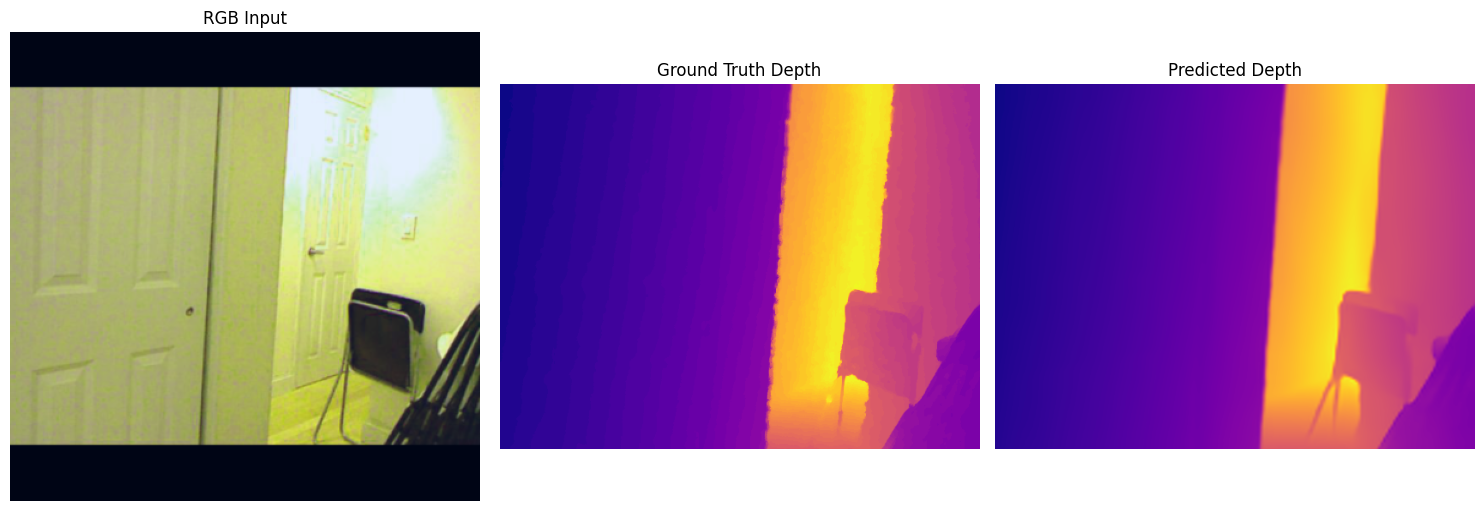

In [7]:
tu.evaluate_model(model, val_loader, config.device,
                  exp_path=os.path.join(config.dataset_path, exp_name), log_input=True)

In [ ]:
tu.generate_test_predictions(model, test_loader, config.device,
                             exp_path=os.path.join(config.dataset_path, exp_name), log_input=True)

In [ ]:
tu.visualize_test_predictions(model, test_loader, config.device,
                              exp_path=os.path.join(config.dataset_path, exp_name), log_input=True)

Visualizing:  43%|█████████████████████████████████████████████████████████████████▋                                                                                        | 35/82 [04:19<05:43,  7.32s/it]